# Deformable convoloution

## Task description

The task involves implementing and comparing the performance of deformable convolutional neural networks with normal convolutional neural networks in an object detection task using the COCO dataset.

# Theoretical questions


<div dir="rtl">

1.  تفاوت بین شبکەهای کانولوشنی عادی و شبکەهای کانولوشنی Deformable را از نظر grid sampling
مقایسه کرده و نتایج مقایسه خود را بنویسید.
> در شبکه های کانولوشنی عادی، grid sampling برای اعمال تبدیل های هندسی ثابت است، اما در شبکه های کانولوشنی Deformable این grid از طریق لایه افست قابل تغییر است در واقع انگار شبکه یاد میگیرد به کجا نگاه کند و حتی با چه orientation ای اطلاعات را وارد شبکه کانولوشنی کند تا بالاترین دقت را بگیرد و نسبت به تغییرات مقاوم تر می شود..
    ![offset1](https://www.mdpi.com/remotesensing/remotesensing-09-01312/article_deploy/html/images/remotesensing-09-01312-g001.png)
2. شبکە های Deformable چگونه می توانند انعطاف پذیری را در Geometric transformation در تصاویر
را به وجود آوردند.
> با استفاده از grid sampling قابل تغییر و لایه offset, این شبکه میتواند تغییرات هندسی در داده و feature map را جبران کند و در واقغ نسبت به آنها مقاوم شود، یعنی در واقع یادگیری الگو های مربوط به Geometric transformation توسط لایه offset انجام شده و شبکه اصلی ویژگی های مهم تر و پیچیده تری را یاد میگیرد.
![Geometric transformation](https://media.springernature.com/m685/springer-static/image/art%3A10.1038%2Fs41598-022-16415-9/MediaObjects/41598_2022_16415_Fig4_HTML.png)
3. به عقیده شما چرا شبکەهای کانولوشنی ساده در مواجهه با تصاویری که آبجکت های تصویر دارای تغییر
یا چرخش فضایی زیادی می باشد دچار مشکلات جدی ای می شود؟
> عمل کانولوشن، به خودی خود نسبت به چرخش فضایی و یا دیگر تغییرات به غیر از جابجایی، ناوردا نیستند، به این معنا که خروجی آنها تغییر میکند، در نتیجه برای یادگیری ویژگی های مربوط به تصاویر دارای چرخش، نیاز به یادگیری ویژگی جدید و در نتیجه در حالت معمول این مشکل با augmnetation های مختلف حل میشود، ولی کانولوشن های Deformable میتوانند این چرخش یا تغییرات دیگر را با لایه offset خود جبران کنند.

4. چگونه آفست های موجود در Convolution Deformable محاسبه می شوند؟
> این آفست ها را در شبکه های کانولوشنی با استفاده از یک شبکه دیگر محاسبه میکنیم، به طور معمول این شبکه خود یک شبکه کانولوشنی است، یعنی یک شبکه کانولوشنی مسئول یادگیری orientation ها مناسب بوده، و سپس بعد از اعمال sampling این را به یک شبکه کانولوشنی مهمولی میدهد، که این feature ها را میتوان به صورت deformed feature در نظر گرفت، در این شبکه ها معمولا یک شبکه دیگر به عنوان mask/modulator وجود دارد که میزان اهمیت یک پیکسل را نیز تشخیص میدهد، و به عنوان نوعی attention رفتار میکنند.
    ![hi](https://www.catalyzex.com/_next/image?url=https%3A%2F%2Fai2-s2-public.s3.amazonaws.com%2Ffigures%2F2017-08-08%2F9218b3e7e447048a070e565b9add26e41d861964%2F1-Figure1-1.png&w=640&q=75)
    
</div>

# Implementation

### Installation

Install the required library for working with the COCO dataset.

In [1]:
!pip install pycocotools

### Import Libraries

Import necessary libraries for the implementation.

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.ops as ops
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.datasets import CocoDetection
from torchvision import datasets
from sklearn.metrics import precision_recall_fscore_support
import gc

import matplotlib.pyplot as plt
import numpy as np

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Device Configuration

Check for GPU availability and configure the device accordingly.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using {device} device")
if torch.cuda.device_count() > 1:
  print("Using", torch.cuda.device_count(), "GPUs!")

using cuda device
Using 2 GPUs!


### Download dataset

Download and unzip the COCO dataset. This section is specific to the Colab environment.

unnecceray if using Kaggle

In [4]:
# Collab
# !wget http://images.cocodataset.org/zips/train2017.zip
# !wget http://images.cocodataset.org/zips/val2017.zip
# !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

# !unzip \*.zip
# !rm *.zip
# For kaggle we import the coco-2017-dataset from the datasets library

## Custom Coco Dataset Class

Define a custom dataset class for loading COCO dataset images and labels. suitible for an object detection task

In [4]:
class CustomCocoDataset(Dataset):
    def __init__(self, root, annFile, transform=None):
        self.coco_dataset = CocoDetection(root=root, annFile=annFile, transform=transform)
        self.transform = transform

    def __len__(self):
        return len(self.coco_dataset)

    def __getitem__(self, idx):
        img, ann = self.coco_dataset[idx]

        # Extract category_id from each annotation
        num_categories = 90  # 90 object categories in COCO dataset
        hot_vector = torch.zeros(num_categories)

        for obj in ann:
            category_id = obj['category_id']
            hot_vector[category_id - 1] = 1

        return img, hot_vector

## Load Dataset

Load the COCO dataset and split it into training and validation sets.

In [5]:
# kaggle
base_path = "../input/coco-2017-dataset/coco2017"

train_path=f"{base_path}/train2017"
train_ann =f"{base_path}/annotations/instances_train2017.json"

val_path=f"{base_path}/val2017"
val_ann =f"{base_path}/annotations/instances_val2017.json"

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Resize([128, 128], antialias=True), # Reshape data
    transforms.Normalize((0.5,), (0.5,)),  # Normalize pixel values to the range [-1, 1]
])

# Create CocoDetection datasets
coco_train_dataset_full = CustomCocoDataset(
    root=train_path,
    annFile=train_ann,
    transform=transform
)

coco_test_dataset = CustomCocoDataset(
    root=val_path,
    annFile=val_ann,
    transform=transform
)

in_channels = 3 # 3 color channels
num_classes = 90 # 90 object categories in COCO dataset

train_len = 16000

# Reduce dataset size
coco_train_dataset = Subset(coco_train_dataset_full, range(train_len))

# Split dataset into train and validation sets
train_size = int(0.8 * len(coco_train_dataset))
val_size = len(coco_train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(coco_train_dataset, [train_size, val_size])
del coco_train_dataset_full
del coco_train_dataset
gc.collect()


print('Number of train samples: ', len(train_dataset))
print('Number of validation samples: ', len(val_dataset))
print('Number of test samples: ', len(val_dataset))

loading annotations into memory...
Done (t=24.80s)
creating index...
index created!
loading annotations into memory...
Done (t=2.62s)
creating index...
index created!
Number of train samples:  12800
Number of validation samples:  3200
Number of test samples:  3200


In [6]:
# Create DataLoaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=False)
test_loader = DataLoader(coco_test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=False)

### Visualizing Dataset:

The code snippet creates a visual representation of a batch from the training dataset, displaying images along with their corresponding categories.

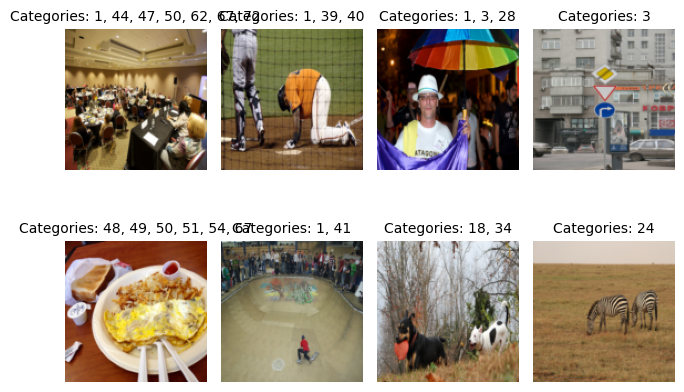

In [8]:
for img, label in train_loader:
    img = img / 2 + 0.5  # unnormalize
    for i in range(8):
      plt.subplot(2, 4, i + 1)
      npimg = img.numpy()[i, :]
      plt.imshow(np.transpose(npimg, (1, 2, 0)))
      # Convert hot vector to a list of categories
      categories = [str(idx + 1) for idx, value in enumerate(label[i].tolist()) if value == 1]
      plt.title(f'Categories: {", ".join(categories)}', fontsize=10)
      plt.axis('off')
    plt.tight_layout()
    plt.show()
    break

## Deformable Convolution Layer
Define a deformable convolutional layer as a module. described in `Deformable ConvNets v2: More Deformable, Better Results`

1. **Offset and Modulator Convolutions:**
   The module includes offset and modulator convolutions responsible for generating offsets and modulating the sampling grid, respectively. These convolutions leverage the input features to compute the spatial transformations required for deformable convolution.

2. **Regular Convolution:**
   The regular convolution applies deformable groups to the input channels and produces the final output. It utilizes the generated deformations, its stride is modified to correctly convolve with expanded feature, with correct deformation and offsets

3. **Deformed Feature Computation:**
   The `deformed_feature` method computes the deformed features by applying the generated offset and modulator to the input image. It uses grid sampling and bilinear interpolation to create a larger feature map, considering the deformations induced by the offsets.

4. **Forward Pass:**
   The `forward` method orchestrates the entire deformable convolution process. It computes the deformed features and passes them through the regular convolution to produce the final output.

5. **Test:**
   The code concludes with a test snippet where an instance of `DeformableConv2d` is created and applied to a randomly generated input tensor. The resulting output shape is printed for verification.


In [7]:
class DeformableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels,
                 kernel_size=3, stride=1, padding=1, dilation=1,
                 deformable_groups=1, bias=False, channelwise=False):
        super(DeformableConv2d, self).__init__()

        assert type(kernel_size) == tuple or type(kernel_size) == int

        self.kernel_size = kernel_size if type(kernel_size) == tuple else (kernel_size, kernel_size)
#         self.offset_kernel = (self.kernel_size[0] * 3, self.kernel_size[1] * 3) # larger FOV for offset
        self.offset_kernel = self.kernel_size
        self.stride = stride if type(stride) == tuple else (stride, stride)
        self.padding = padding
        self.dilation = dilation

        deformable_groups = deformable_groups * (in_channels if channelwise else 1)

        self.offset_conv = nn.Conv2d(
            in_channels,
#             deformable_groups * 2,
            2 * deformable_groups * self.kernel_size[0] * self.kernel_size[1],
            kernel_size=self.offset_kernel,
            stride=1, padding='same',
            dilation=self.dilation, bias=False
        )

        self.modulator_conv = nn.Conv2d(
            in_channels,
#             deformable_groups,
            deformable_groups * self.kernel_size[0] * self.kernel_size[1],
            kernel_size=self.offset_kernel,
            stride=1, padding='same',
            dilation=self.dilation, bias=False
        )

        self.def_channel = deformable_groups * self.kernel_size[0] * self.kernel_size[1]
        
        self.regular_conv = nn.Conv2d(
#             in_channels,
            deformable_groups * in_channels,
            out_channels,
            kernel_size=self.kernel_size,
#             stride = stride,
            stride=(self.stride[0] * self.kernel_size[0],self.stride[1] * self.kernel_size[1]),
            padding=self.padding,
            dilation=self.dilation, bias=bias
        )
        

    def deformed_feature(self, x):
        offset = self.offset_conv(x)
        mask = 2 * torch.sigmoid(self.modulator_conv(x))
        N, C, H, W = x.size()
        # Generate grid
        grid_y, grid_x = torch.meshgrid(torch.arange(H), torch.arange(W))
        grid_y = grid_y.to(device=x.device, dtype=torch.float32)
        grid_x = grid_x.to(device=x.device, dtype=torch.float32)
        grid_y = grid_y.view(1, H, W) + offset[:, :self.def_channel, :, :]
        grid_x = grid_x.view(1, H, W) + offset[:, self.def_channel: , :, :]
        grid_y = 2 * grid_y / (H - 1) - 1
        grid_x = 2 * grid_x / (W - 1) - 1

        # Interpolate features using grid and mask
        grid = torch.stack((grid_x, grid_y), dim=-1)
        features = torch.zeros((N, C, H * self.kernel_size[0], W * self.kernel_size[1]))
        
        # create bigger feature, offset applied
        for i in range(self.def_channel):
            x0 = i % self.kernel_size[0]
            y0 = int(i / self.kernel_size[0])
            g = grid[:, i, :, :, :]
            # sample
            samples = nn.functional.grid_sample(x, g, mode='bilinear', align_corners=False)
            # apply mask
            samples = samples * mask[:, i:i+1, :, :]
            features[:, :,
                y0:(y0 + H * self.kernel_size[0]):self.kernel_size[0],
                x0:W * self.kernel_size[1]:self.kernel_size[1]
            ] = samples
        
        features = features.to(device=x.device)
        
        return features

    def forward(self, x):
        # Our implementation
        features = self.deformed_feature(x)
        features = self.regular_conv(features)
        # Using pytorch 
#         offset = self.offset_conv(x)
#         mask = 2 * torch.sigmoid(self.modulator_conv(x))
#         features = ops.deform_conv2d(
#             input=x,
#               offset=offset,
#               weight=self.regular_conv.weight,
#               bias=self.regular_conv.bias,
#               mask=mask,
#               stride=self.stride,
#               dilation=self.dilation,padding=self.padding)
        return features

# Test
deformable_conv = DeformableConv2d(in_channels=10, out_channels=64, kernel_size=3, stride=1, padding=1, deformable_groups=1)
x = torch.randn(4, 10, 224, 224)
output = deformable_conv(x)
print(output.shape)

torch.Size([4, 64, 224, 224])


## Deformable ResNet Block and Classifier

The provided code defines two classes: `ResNetBlock` and `CocoClassifierDeform`. The `ResNetBlock` class represents a basic residual block with optional deformable convolutions. It consists of convolutional layers, batch normalization, and a skip connection for residual learning. The `CocoClassifierDeform` class leverages these blocks to construct a classifier with deformable convolutions. It combines ResNet-inspired modules with the UNet encoder structure. The classifier incorporates deformable convolutions in initial layers for enhanced spatial feature extraction, transitioning to normal convolutions for later layers without spatial features. The final layer includes a global average pooling, fully connected layer, batch normalization, and sigmoid activation, making it suitable for binary classification tasks.


In [8]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, deformable=False):
        super(ResNetBlock, self).__init__()

#         conv = nn.Conv2d if deformable==False else ops.DeformConv2d
        conv = nn.Conv2d if deformable==False else DeformableConv2d
        
        self.conv1 = conv(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True)
        self.BN1 = nn.BatchNorm2d(out_channels)
        self.BN_res = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv3 = conv(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True)
        self.BN2 = nn.BatchNorm2d(out_channels)
        self.BN3 = nn.BatchNorm2d(out_channels)
        
        # Normal convoloution for bottleneck layer
        self.conv_res = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=True)
        
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        residual = x.clone()
        residual = self.conv_res(residual)
        residual = self.BN_res(residual)
        residual = torch.relu(residual)
        x = self.conv1(x)
        x = self.BN1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = self.BN2(x)
        x = torch.relu(x)
        x = x + residual
        x = self.conv3(x)
        x = self.BN3(x)
        x = torch.relu(x)
        x = self.pool(x)
        return x

# inspired by combining ResNet modules and the UNet encoder
class CocoClassifierDeform(nn.Module):
    def __init__(self, num_classes,in_channels, deformable=False):
        super(CocoClassifierDeform, self).__init__()
    
        # deformable conv for first layers, where the network is 'looking'
        self.block1 = ResNetBlock(in_channels, 32, deformable=deformable)
        self.block2 = ResNetBlock(32, 64, deformable=deformable)
        # Normal conv for last layers without spatial features
        self.block4 = ResNetBlock(128, 512, deformable=False)
        self.block3 = ResNetBlock(64, 128, deformable=False)

        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        self.BN = nn.BatchNorm1d(num_classes)
        self.classifier = nn.Sigmoid()
    
    def conv_features(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        return x
        
    def forward(self, x):
        x = self.conv_features(x)
        x = self.gap(x)
        x = torch.squeeze(x, dim=(2, 3))
        x = self.fc(x)
        x = self.BN(x)
        x = self.classifier(x)
        return x

### Model Configuration
Configure the model for a normal convolutional neural network for the object detection task.

In [13]:
normal_model = CocoClassifierDeform(
    in_channels=in_channels, num_classes=num_classes, deformable=False
).to(device)

if torch.cuda.device_count() > 1:
    print("using", torch.cuda.device_count(), "GPUs!")
    normal_model = nn.DataParallel(normal_model)
    normal_model = normal_model.to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(normal_model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

normal_model

using 2 GPUs!


DataParallel(
  (module): CocoClassifierDeform(
    (block1): ResNetBlock(
      (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (BN1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (BN_res): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (BN2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (BN3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_res): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (block2): ResNetBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (BN1): BatchNorm2d(64, eps=1e-05

### Saving models

create directories to save model parameters into

In [143]:
!mkdir normal
!mkdir deformed

### Training Loop (Normal Convolution)
Train the normal convolutional model on the COCO dataset and evaluate on the validation set.

In [13]:
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support

precision_list_norm = []
recall_list_norm = []
f1_list_norm = []
loss_list_norm = []

num_epochs = 10

# Train the model
for epoch in range(num_epochs):
    normal_model.train()
    running_loss = 0.0
    all_predicted_labels = []
    all_true_labels = []
    
    # Training
    for inputs, labels in tqdm(train_loader, desc=f'Train - epoch {epoch+1}/{num_epochs}'):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = normal_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    #  Validation
    normal_model.eval()
    for inputs, labels in tqdm(val_loader, desc=f'Validation - epoch {epoch+1}/{num_epochs}'):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = normal_model(inputs)
        loss = criterion(outputs, labels)
        # Measure accuracy
        predicted = (outputs > 0.5).float()
        all_predicted_labels.extend(predicted.cpu().numpy().flatten())
        all_true_labels.extend(labels.cpu().numpy().flatten())
        running_loss += loss.item()

    # Calculate average loss and accuracy for the epoch
    epoch_loss = running_loss / len(val_loader)

    # Measure precision, recall, and F1 score using scikit-learn
    precision, recall, f1, _ = precision_recall_fscore_support(all_true_labels, all_predicted_labels, average='binary')

    precision_list_norm.append(precision)
    recall_list_norm.append(recall)
    f1_list_norm.append(f1)

    scheduler.step()

    # Save model checkpoint
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': normal_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': loss,
    }
    torch.save(checkpoint, f'./normal/model_checkpoint{epoch}_Q2.pth')


    print(f'Loss: {epoch_loss:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')
    loss_list_norm.append(epoch_loss)

Validation - epoch 1/10: 100%|██████████| 25/25 [00:15<00:00,  1.63it/s]


Loss: 0.3712, Precision: 0.5611, Recall: 0.1477, F1: 0.2339


Validation - epoch 2/10: 100%|██████████| 25/25 [00:12<00:00,  2.07it/s]


Loss: 0.2384, Precision: 0.6133, Recall: 0.1431, F1: 0.2321


Validation - epoch 3/10: 100%|██████████| 25/25 [00:12<00:00,  2.04it/s]


Loss: 0.1826, Precision: 0.6439, Recall: 0.1254, F1: 0.2099


Validation - epoch 4/10: 100%|██████████| 25/25 [00:12<00:00,  2.03it/s]


Loss: 0.1535, Precision: 0.6061, Recall: 0.1696, F1: 0.2650


Validation - epoch 5/10: 100%|██████████| 25/25 [00:12<00:00,  2.03it/s]


Loss: 0.1372, Precision: 0.6277, Recall: 0.1647, F1: 0.2609


Validation - epoch 6/10: 100%|██████████| 25/25 [00:12<00:00,  2.04it/s]


Loss: 0.1337, Precision: 0.6712, Recall: 0.1559, F1: 0.2530


Validation - epoch 7/10: 100%|██████████| 25/25 [00:12<00:00,  2.05it/s]


Loss: 0.1318, Precision: 0.6862, Recall: 0.1530, F1: 0.2502


Validation - epoch 8/10: 100%|██████████| 25/25 [00:12<00:00,  2.05it/s]


Loss: 0.1305, Precision: 0.6957, Recall: 0.1495, F1: 0.2461


Validation - epoch 9/10: 100%|██████████| 25/25 [00:12<00:00,  2.04it/s]


Loss: 0.1292, Precision: 0.6931, Recall: 0.1578, F1: 0.2571


Validation - epoch 10/10: 100%|██████████| 25/25 [00:12<00:00,  1.98it/s]


Loss: 0.1276, Precision: 0.6759, Recall: 0.1628, F1: 0.2624


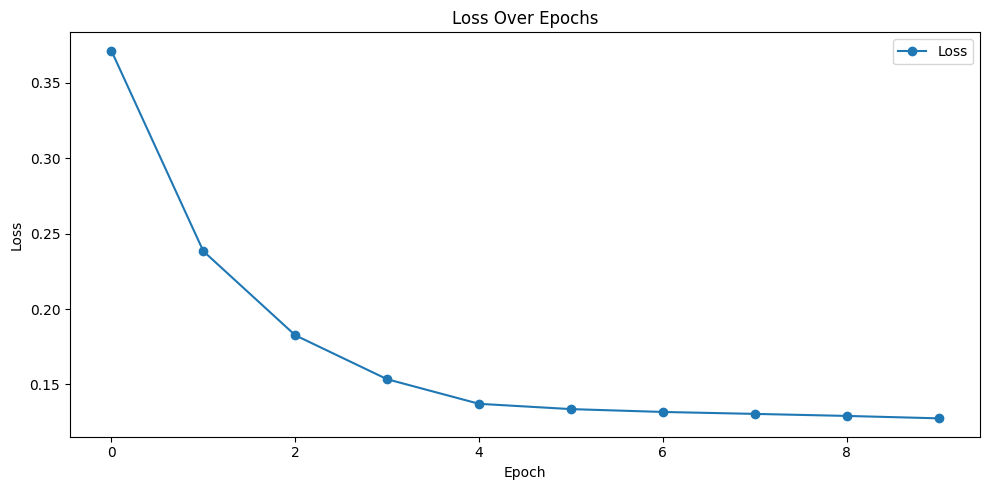

In [14]:
# Plotting
plt.figure(figsize=(10, 5))

plt.plot(loss_list_norm, label='Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

this plot shows steadily decreasing loss showing a good training process.

In [17]:
from IPython.display import FileLink
FileLink(r'normal/model_checkpoint9_Q2.pth')

/kaggle/working/normal/model_checkpoint9_Q2.pth

### Evaluate on Test Set (Normal Convolution)
Evaluate the performance of the normal convolutional model on the test set.

In [18]:
# Evaluate on the test set
normal_model.eval()
all_predicted_labels_test = []
all_true_labels_test = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='Evaluating on test set'):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = normal_model(inputs)
        predicted = (outputs > 0.5).float()
        all_predicted_labels_test.extend(predicted.cpu().numpy().flatten())
        all_true_labels_test.extend(labels.cpu().numpy().flatten())

# Measure precision, recall, and F1 score on the test set
precision_test, recall_test, f1_test, _ = precision_recall_fscore_support(all_true_labels_test, all_predicted_labels_test, average='binary')

print(f'\nNormal model Precision on test dataset: {precision_test:.4f}')
print(f'Normal model Recall on test dataset: {recall_test:.4f}')
print(f'Normal model F1 score on test dataset: {f1_test:.4f}')

Evaluating on test set: 100%|██████████| 40/40 [00:24<00:00,  1.64it/s]



Normal model Precision on test dataset: 0.6617
Normal model Recall on test dataset: 0.1569
Normal model F1 score on test dataset: 0.2537


### Model Configuration with Deformable Convolution
Configure the model with deformable convolutional layers for the object detection task.

In [144]:
deformable_model = CocoClassifierDeform(
    in_channels=in_channels, num_classes=num_classes, deformable=True
).to(device)

if torch.cuda.device_count() > 1:
    print("using", torch.cuda.device_count(), "GPUs!")
    deformable_model = nn.DataParallel(deformable_model)
    deformable_model = deformable_model.to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(deformable_model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

deformable_model

using 2 GPUs!


DataParallel(
  (module): CocoClassifierDeform(
    (block1): ResNetBlock(
      (conv1): DeformableConv2d(
        (offset_conv): Conv2d(3, 18, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
        (modulator_conv): Conv2d(3, 9, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
        (regular_conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
      )
      (BN1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (BN_res): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv3): DeformableConv2d(
        (offset_conv): Conv2d(32, 18, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
        (modulator_conv): Conv2d(32, 9, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
        (regular_conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    

### Training Loop (Deformable Convolution)
Train the model with deformable convolutional layers on the COCO dataset and evaluate on the validation set.

In [145]:
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support

precision_list_deform = []
recall_list_deform = []
f1_list_deform = []
loss_list_deform = []

num_epochs = 10

# Train the model
for epoch in range(num_epochs):
    deformable_model.train()
    running_loss = 0.0
    all_predicted_labels = []
    all_true_labels = []

    # Training
    for inputs, labels in tqdm(train_loader, desc=f'Train - epoch {epoch+1}/{num_epochs}'):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = deformable_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
    #  Validation
    deformable_model.eval()
    for inputs, labels in tqdm(val_loader, desc=f'Validation - epoch {epoch+1}/{num_epochs}'):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = deformable_model(inputs)
        loss = criterion(outputs, labels)
        # Measure accuracy
        predicted = (outputs > 0.5).float()
        all_predicted_labels.extend(predicted.cpu().numpy().flatten())
        all_true_labels.extend(labels.cpu().numpy().flatten())
        running_loss += loss.item()

    # Calculate average loss and accuracy for the epoch
    epoch_loss = running_loss / len(val_loader)

    # Measure precision, recall, and F1 score using scikit-learn
    precision, recall, f1, _ = precision_recall_fscore_support(all_true_labels, all_predicted_labels, average='binary')

    precision_list_deform.append(precision)
    recall_list_deform.append(recall)
    f1_list_deform.append(f1)

    scheduler.step()

    # Save model checkpoint
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': deformable_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': loss,
    }
    torch.save(checkpoint, f'./deformed/model_checkpoint{epoch}_Q2.pth')


    print(f'Loss: {epoch_loss:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')
    loss_list_deform.append(epoch_loss)

Validation - epoch 1/10: 100%|██████████| 25/25 [00:19<00:00,  1.29it/s]


Loss: 0.3701, Precision: 0.5424, Recall: 0.1559, F1: 0.2422


Validation - epoch 2/10: 100%|██████████| 25/25 [00:13<00:00,  1.92it/s]


Loss: 0.2365, Precision: 0.6123, Recall: 0.1342, F1: 0.2202


Validation - epoch 3/10: 100%|██████████| 25/25 [00:13<00:00,  1.85it/s]


Loss: 0.1820, Precision: 0.5939, Recall: 0.1553, F1: 0.2462


Validation - epoch 4/10: 100%|██████████| 25/25 [00:13<00:00,  1.87it/s]


Loss: 0.1510, Precision: 0.5947, Recall: 0.1642, F1: 0.2573


Validation - epoch 5/10: 100%|██████████| 25/25 [00:12<00:00,  1.93it/s]


Loss: 0.1364, Precision: 0.6276, Recall: 0.1440, F1: 0.2342


Validation - epoch 6/10: 100%|██████████| 25/25 [00:12<00:00,  1.93it/s]


Loss: 0.1333, Precision: 0.6471, Recall: 0.1366, F1: 0.2256


Validation - epoch 7/10: 100%|██████████| 25/25 [00:12<00:00,  1.95it/s]


Loss: 0.1322, Precision: 0.6442, Recall: 0.1412, F1: 0.2316


Validation - epoch 8/10: 100%|██████████| 25/25 [00:13<00:00,  1.87it/s]


Loss: 0.1303, Precision: 0.6709, Recall: 0.1322, F1: 0.2208


Validation - epoch 9/10: 100%|██████████| 25/25 [00:12<00:00,  1.95it/s]


Loss: 0.1287, Precision: 0.6560, Recall: 0.1402, F1: 0.2310


Validation - epoch 10/10: 100%|██████████| 25/25 [00:12<00:00,  1.94it/s]


Loss: 0.1271, Precision: 0.6677, Recall: 0.1347, F1: 0.2241


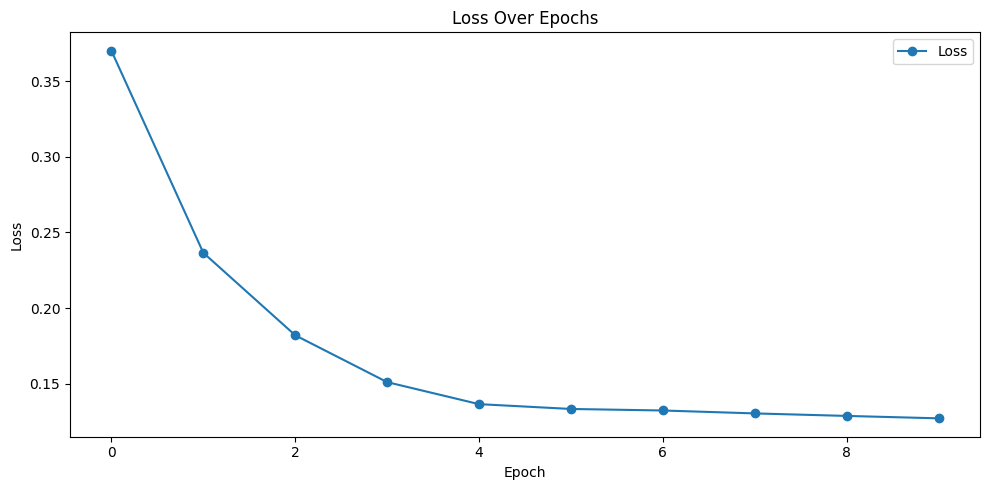

In [146]:
# Plotting
plt.figure(figsize=(10, 5))

plt.plot(loss_list_deform, label='Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

this plot shows steadily decreasing loss showing a good training process.

In [24]:
from IPython.display import FileLink
FileLink(r'deformed/model_checkpoint9_Q2.pth')

/kaggle/working/deformed/model_checkpoint9_Q2.pth

### Evaluate on Test Set (Deformable Convolution)
Evaluate the performance of the model with deformable convolutional layers on the test set.

In [22]:
# Evaluate on the test set
deformable_model.eval()
all_predicted_labels_test = []
all_true_labels_test = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='Evaluating on test set'):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = deformable_model(inputs)
        predicted = (outputs > 0.5).float()
        all_predicted_labels_test.extend(predicted.cpu().numpy().flatten())
        all_true_labels_test.extend(labels.cpu().numpy().flatten())

# Measure precision, recall, and F1 score on the test set
precision_test, recall_test, f1_test, _ = precision_recall_fscore_support(all_true_labels_test, all_predicted_labels_test, average='binary')

print(f'\nNormal model Precision on test dataset: {precision_test:.4f}')
print(f'Normal model Recall on test dataset: {recall_test:.4f}')
print(f'Normal model F1 score on test dataset: {f1_test:.4f}')

Evaluating on test set: 100%|██████████| 40/40 [00:18<00:00,  2.14it/s]



Normal model Precision on test dataset: 0.6687
Normal model Recall on test dataset: 0.1555
Normal model F1 score on test dataset: 0.2523


### Loading models for benchmarks

In [11]:
checkpoint = torch.load('/kaggle/input/deformed-weights/model_checkpoint9_Q2.pth')
deformable_model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [14]:
checkpoint = torch.load('/kaggle/input/deformed-weights/normal/model_checkpoint9_Q2.pth')
normal_model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

### Visualization
Visualize the deformable features compared to the input images.

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


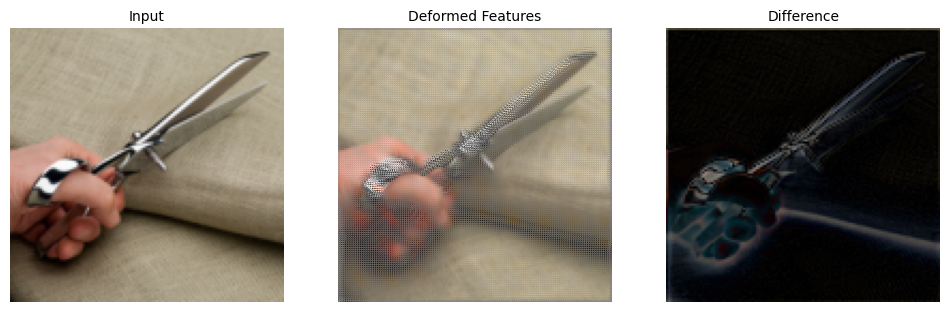

In [15]:
visualizer = deformable_model.module if type(deformable_model) == nn.DataParallel else deformable_model

with torch.no_grad():
    plt.figure(figsize=(12, 5))
    for inputs, labels in train_loader:  # Assuming train_loader is your data loader
        inputs, labels = inputs.to(device), labels.to(device)
        deformed = visualizer.block1.conv1
        features = deformed.deformed_feature(inputs)

        # Denormalize the images
        inputs_denormalized = inputs / 2 + 0.5
        features_denormalized = features / 2 + 0.5

        # Clamp the values to be within the valid range [0, 1]
        inputs_denormalized = torch.clamp(inputs_denormalized, 0, 1)
        features_denormalized = torch.clamp(features_denormalized, 0, 1)
        
        kw, kh = deformed.kernel_size
        filters = torch.ones(1, 1, kw, kh).to(device) / 9
        mean_feature = torch.zeros_like(inputs_denormalized)
        mean_feature[:,0:1,:,:] = nn.functional.conv2d(features_denormalized[:,0:1,:,:], filters, padding=1, stride=(kw,kh))
        mean_feature[:,1:2,:,:] = nn.functional.conv2d(features_denormalized[:,1:2,:,:], filters, padding=1, stride=(kw,kh))
        mean_feature[:,2:3,:,:] = nn.functional.conv2d(features_denormalized[:,2:3,:,:], filters, padding=1, stride=(kw,kh))
        # Calculate the difference between input and deformed features
        difference = torch.abs(inputs_denormalized - mean_feature)

        plt.subplot(1, 3, 1)
        plt.imshow(inputs_denormalized.cpu()[4].permute(1, 2, 0), cmap='Greys')
        plt.title(f'Input', fontsize=10)
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(features_denormalized.cpu()[4].permute(1, 2, 0), cmap='Greys')
        plt.title(f'Deformed Features', fontsize=10)
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(difference.cpu()[4].permute(1, 2, 0), cmap='viridis')
        plt.title(f'Difference', fontsize=10)
        plt.axis('off')

        break  # first batch

    plt.show()

these plots show how the deformed convoloutions sample the original image.

the difference map shows us how the model is selecting the features

### Receptive field visualization

here by using gradient descent, we see which parts of the input influence a particular feature map from our image, visualizing the receptive field of our network.

1.0
1.0


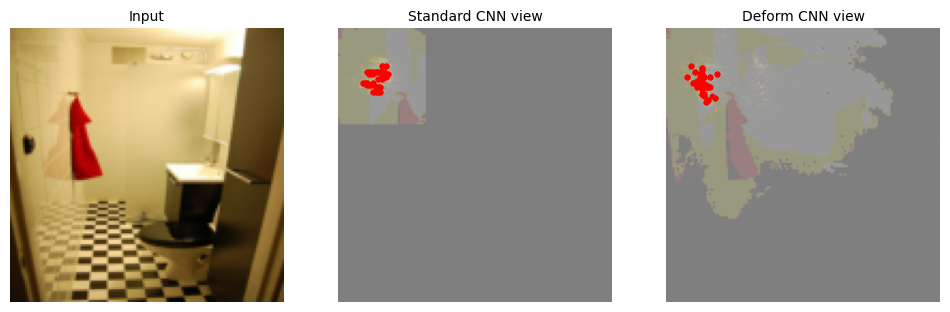

In [142]:
visualizer = deformable_model.module if type(deformable_model) == nn.DataParallel else deformable_model
visualizer_norm = normal_model.module if type(deformable_model) == nn.DataParallel else normal_model
# visualizer_norm.eval()
# visualizer.eval()
models = [visualizer_norm, visualizer]
plt.figure(figsize=(12, 5))
for inputs, labels in train_loader:  # Assuming train_loader is your data loader
    inputs, labels = inputs.to(device), labels.to(device)
    image = inputs[0:1]
    image.requires_grad = True
    image_ = image[0].detach().cpu().permute(1, 2, 0).numpy()
    masked = []
    max_coords = []
    for model in models:
        out = model.block1(image)
        out = model.block2(out)
        out = model.block3(out)
#         out = model.block4(out)
        grad = torch.zeros_like(out, requires_grad=False)
        grad[0, 0, 2, 2] = 1
        
        out.backward(gradient=grad)

        # Retrieve the gradient of the input image.
        gradient_of_input = image.grad[0, 0].cpu().data.numpy()
        # Normalize the gradient.
        activations = np.abs(gradient_of_input / np.amax(gradient_of_input))
        
        activations = activations - np.min(activations[:])
        activations = activations / np.max(activations[:])
            
        print(np.max(activations[:]))
        if np.isnan(np.max(activations[:])):
            print('Rerun code')
            
        activations = np.stack([activations, activations, activations], axis=2)
    
        masked_image = (image_ * activations)
        
        # Denormalize the images
        masked_image = masked_image / 2 + 0.5
        
        # Clamp the values to be within the valid range [0, 1]
#         masked_image = np.clamp(masked_image, 0, 1)
        masked_image[masked_image > 0.5] *= 1.2
    
        masked.append(masked_image)
        
        num_top_nodes = 100
        top_indices = np.argpartition(activations.flatten(), -num_top_nodes)[-num_top_nodes:]
        max_coords.append(np.unravel_index(top_indices, activations.shape))
    
    image_ = image_ / 2 + 0.5     
#     image_ = torch.clamp(image_, 0, 1)
    plt.subplot(1, 3, 1)
    plt.imshow(image_, cmap='Greys')
    plt.title(f'Input', fontsize=10)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(masked[0])
    plt.title(f'Standard CNN view', fontsize=10)
    plt.scatter(max_coords[0][1], max_coords[0][0], color='red', s=10) 
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(masked[1])
    plt.title(f'Deform CNN view', fontsize=10)
    plt.scatter(max_coords[1][1], max_coords[1][0], color='red', s=10) 
    plt.axis('off')

    
    break  # first batch


Here we visualize the recepetive field, showcasing a wider receptive field for deformable nets.

### Performance Comparison
Compare the performance of the normal convolutional model and the model with deformable convolutional layers.

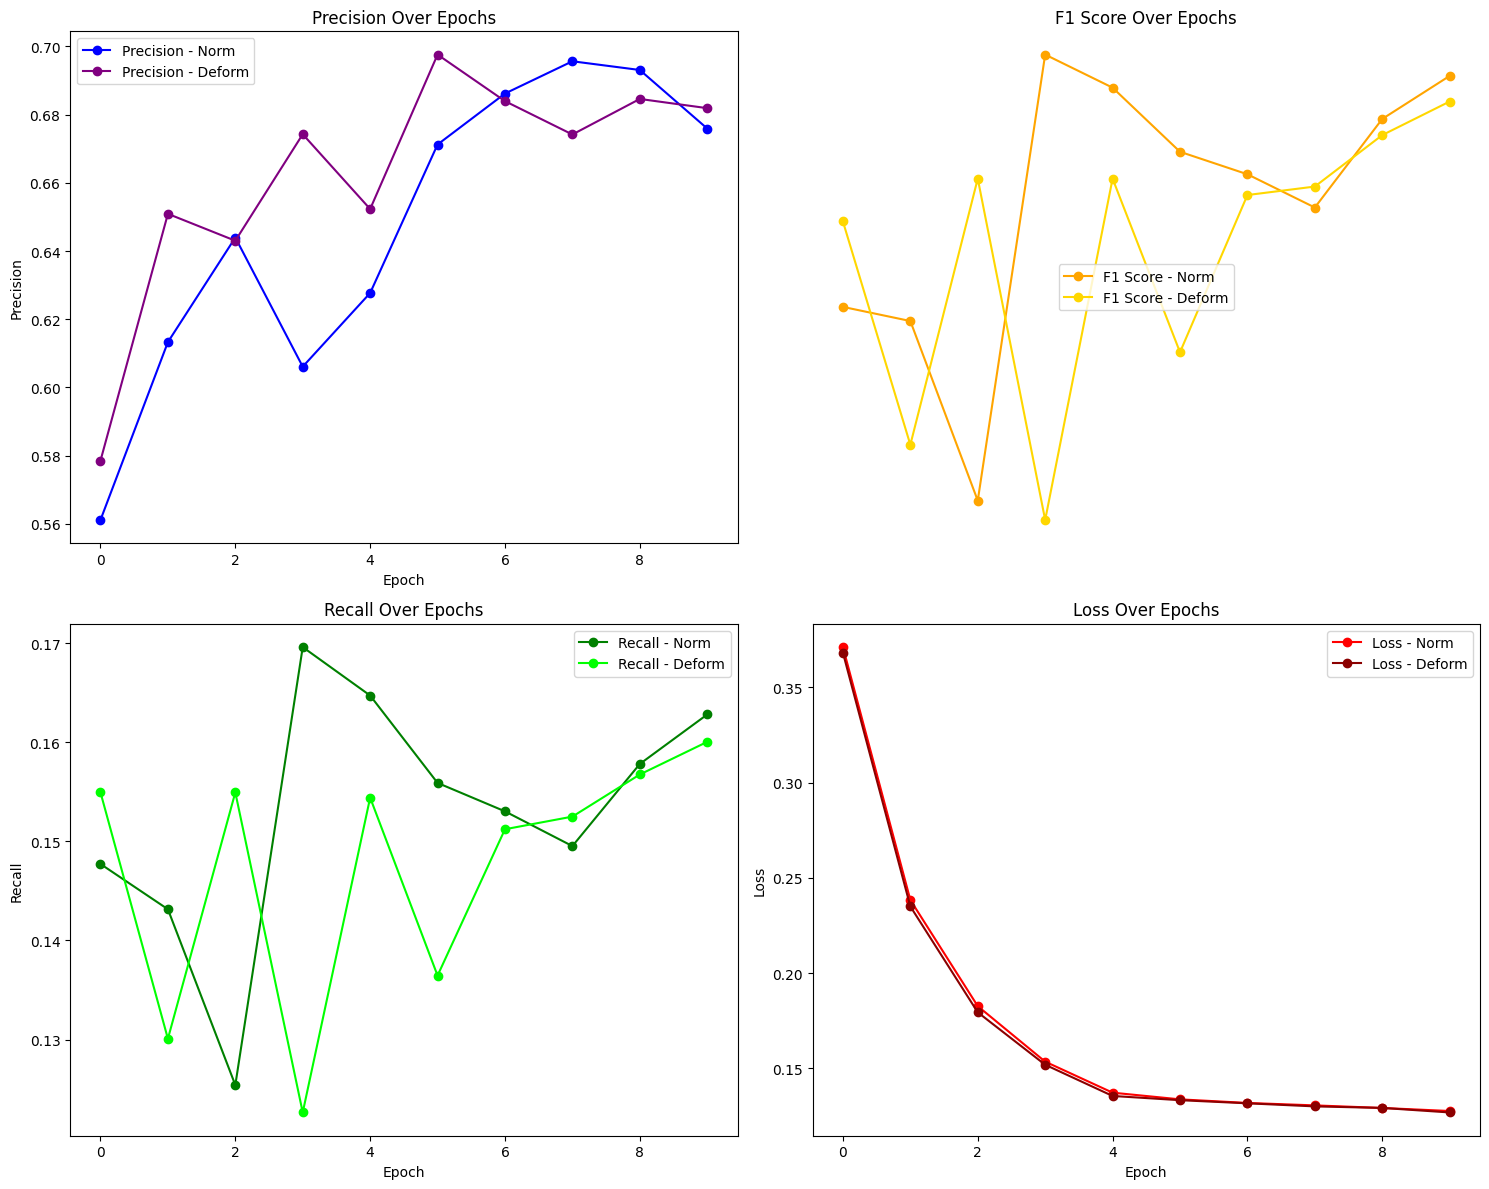

In [37]:
# Plotting comparison
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Plot precision
axs[0, 0].plot(precision_list_norm, label='Precision - Norm', marker='o', color='blue')
axs[0, 0].plot(precision_list_deform, label='Precision - Deform', marker='o', color='purple')
axs[0, 0].set_title('Precision Over Epochs')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Precision')
axs[0, 0].legend()

# Plot recall
axs[1, 0].plot(recall_list_norm, label='Recall - Norm', marker='o', color='green')
axs[1, 0].plot(recall_list_deform, label='Recall - Deform', marker='o', color='lime')
axs[1, 0].set_title('Recall Over Epochs')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Recall')
axs[1, 0].legend()

# Plot F1 score
axs[0, 1].plot(f1_list_norm, label='F1 Score - Norm', marker='o', color='orange')
axs[0, 1].plot(f1_list_deform, label='F1 Score - Deform', marker='o', color='gold')
axs[0, 1].set_title('F1 Score Over Epochs')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('F1 Score')
axs[0, 1].legend()

# Plot loss
axs[1, 1].plot(loss_list_norm, label='Loss - Norm', marker='o', color='red')
axs[1, 1].plot(loss_list_deform, label='Loss - Deform', marker='o', color='darkred')
axs[1, 1].set_title('Loss Over Epochs')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].legend()

# Adding a common legend for the second column
axs[0, 1].axis('off')
axs[0, 1].legend(loc='center', bbox_to_anchor=(0.5, 0.5))

plt.tight_layout()
plt.show()